# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 2            
model_seed = 2           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6914 | Test Loss 0.6927 | accs Train 0.5275 Test 0.5000


Epoch 100/2000: Train Loss 0.5829 | Test Loss 0.5721 | accs Train 0.6725 Test 0.6825


Epoch 200/2000: Train Loss 0.0162 | Test Loss 0.0232 | accs Train 0.9975 Test 0.9940


Epoch 300/2000: Train Loss 0.0018 | Test Loss 0.0083 | accs Train 1.0000 Test 0.9978


Epoch 400/2000: Train Loss 0.0005 | Test Loss 0.0071 | accs Train 1.0000 Test 0.9982


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0066 | accs Train 1.0000 Test 0.9985


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0064 | accs Train 1.0000 Test 0.9985


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0062 | accs Train 1.0000 Test 0.9985


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0062 | accs Train 1.0000 Test 0.9985


Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.0061 | accs Train 1.0000 Test 0.9985


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9985


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9985


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0072 | accs Train 1.0000 Test 0.9985


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0073 | accs Train 1.0000 Test 0.9985


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0074 | accs Train 1.0000 Test 0.9985


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0075 | accs Train 1.0000 Test 0.9985


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0077 | accs Train 1.0000 Test 0.9985


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0078 | accs Train 1.0000 Test 0.9985


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0079 | accs Train 1.0000 Test 0.9985


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0081 | accs Train 1.0000 Test 0.9985


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0082 | accs Train 1.0000 Test 0.9985
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6920 | Test Loss 0.6926 | accs Train 0.5220 Test 0.5000


Epoch 100/2000: Train Loss 0.5908 | Test Loss 0.5762 | accs Train 0.6659 Test 0.6840


Epoch 200/2000: Train Loss 0.0943 | Test Loss 0.0502 | accs Train 0.9732 Test 0.9950


Epoch 300/2000: Train Loss 0.0548 | Test Loss 0.0317 | accs Train 0.9829 Test 0.9932


Epoch 400/2000: Train Loss 0.0395 | Test Loss 0.0358 | accs Train 0.9878 Test 0.9890


Epoch 500/2000: Train Loss 0.0294 | Test Loss 0.0409 | accs Train 0.9927 Test 0.9865


Epoch 600/2000: Train Loss 0.0216 | Test Loss 0.0468 | accs Train 0.9927 Test 0.9860


Epoch 700/2000: Train Loss 0.0175 | Test Loss 0.0500 | accs Train 0.9927 Test 0.9830


Epoch 800/2000: Train Loss 0.0150 | Test Loss 0.0555 | accs Train 0.9951 Test 0.9828


Epoch 900/2000: Train Loss 0.0130 | Test Loss 0.0619 | accs Train 0.9976 Test 0.9820


Epoch 1000/2000: Train Loss 0.0114 | Test Loss 0.0684 | accs Train 0.9976 Test 0.9808


Epoch 1100/2000: Train Loss 0.0100 | Test Loss 0.0737 | accs Train 0.9976 Test 0.9802


Epoch 1200/2000: Train Loss 0.0090 | Test Loss 0.0801 | accs Train 0.9976 Test 0.9805


Epoch 1300/2000: Train Loss 0.0082 | Test Loss 0.0836 | accs Train 0.9976 Test 0.9800


Epoch 1400/2000: Train Loss 0.0077 | Test Loss 0.0871 | accs Train 0.9976 Test 0.9802


Epoch 1500/2000: Train Loss 0.0076 | Test Loss 0.0901 | accs Train 0.9976 Test 0.9808


Epoch 1600/2000: Train Loss 0.0072 | Test Loss 0.0959 | accs Train 0.9976 Test 0.9805


Epoch 1700/2000: Train Loss 0.0070 | Test Loss 0.0993 | accs Train 0.9976 Test 0.9805


Epoch 1800/2000: Train Loss 0.0064 | Test Loss 0.0999 | accs Train 0.9951 Test 0.9812


Epoch 1900/2000: Train Loss 0.0060 | Test Loss 0.1024 | accs Train 0.9976 Test 0.9802


Epoch 2000/2000: Train Loss 0.0061 | Test Loss 0.1038 | accs Train 0.9951 Test 0.9810
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6913 | Test Loss 0.6927 | accs Train 0.5286 Test 0.5000


Epoch 100/2000: Train Loss 0.5956 | Test Loss 0.5733 | accs Train 0.6571 Test 0.6865


Epoch 200/2000: Train Loss 0.1337 | Test Loss 0.0662 | accs Train 0.9548 Test 0.9938


Epoch 300/2000: Train Loss 0.0975 | Test Loss 0.0493 | accs Train 0.9571 Test 0.9898


Epoch 400/2000: Train Loss 0.0782 | Test Loss 0.0546 | accs Train 0.9690 Test 0.9845


Epoch 500/2000: Train Loss 0.0750 | Test Loss 0.0577 | accs Train 0.9619 Test 0.9795


Epoch 600/2000: Train Loss 0.0511 | Test Loss 0.0619 | accs Train 0.9833 Test 0.9765


Epoch 700/2000: Train Loss 0.0434 | Test Loss 0.0688 | accs Train 0.9857 Test 0.9732


Epoch 800/2000: Train Loss 0.0375 | Test Loss 0.0764 | accs Train 0.9881 Test 0.9708


Epoch 900/2000: Train Loss 0.0337 | Test Loss 0.0784 | accs Train 0.9857 Test 0.9702


Epoch 1000/2000: Train Loss 0.0289 | Test Loss 0.0905 | accs Train 0.9881 Test 0.9673


Epoch 1100/2000: Train Loss 0.0269 | Test Loss 0.0897 | accs Train 0.9905 Test 0.9695


Epoch 1200/2000: Train Loss 0.0236 | Test Loss 0.0982 | accs Train 0.9929 Test 0.9685


Epoch 1300/2000: Train Loss 0.0216 | Test Loss 0.1027 | accs Train 0.9952 Test 0.9677


Epoch 1400/2000: Train Loss 0.0196 | Test Loss 0.1049 | accs Train 0.9952 Test 0.9685


Epoch 1500/2000: Train Loss 0.0190 | Test Loss 0.1212 | accs Train 0.9952 Test 0.9630


Epoch 1600/2000: Train Loss 0.0170 | Test Loss 0.1130 | accs Train 0.9952 Test 0.9677


Epoch 1700/2000: Train Loss 0.0162 | Test Loss 0.1155 | accs Train 0.9952 Test 0.9673


Epoch 1800/2000: Train Loss 0.0155 | Test Loss 0.1240 | accs Train 0.9952 Test 0.9665


Epoch 1900/2000: Train Loss 0.0149 | Test Loss 0.1251 | accs Train 0.9952 Test 0.9665


Epoch 2000/2000: Train Loss 0.0146 | Test Loss 0.1242 | accs Train 0.9905 Test 0.9675
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6920 | Test Loss 0.6926 | accs Train 0.5222 Test 0.5000


Epoch 100/2000: Train Loss 0.6178 | Test Loss 0.5877 | accs Train 0.6511 Test 0.6767


Epoch 200/2000: Train Loss 0.2795 | Test Loss 0.1469 | accs Train 0.9022 Test 0.9862


Epoch 300/2000: Train Loss 0.2411 | Test Loss 0.1301 | accs Train 0.9044 Test 0.9722


Epoch 400/2000: Train Loss 0.2220 | Test Loss 0.1374 | accs Train 0.9089 Test 0.9565


Epoch 500/2000: Train Loss 0.2037 | Test Loss 0.1489 | accs Train 0.9156 Test 0.9490


Epoch 600/2000: Train Loss 0.1856 | Test Loss 0.1614 | accs Train 0.9156 Test 0.9430


Epoch 700/2000: Train Loss 0.1720 | Test Loss 0.1703 | accs Train 0.9289 Test 0.9383


Epoch 800/2000: Train Loss 0.1634 | Test Loss 0.1942 | accs Train 0.9244 Test 0.9320


Epoch 900/2000: Train Loss 0.1524 | Test Loss 0.2029 | accs Train 0.9311 Test 0.9320


Epoch 1000/2000: Train Loss 0.1438 | Test Loss 0.2331 | accs Train 0.9378 Test 0.9215


Epoch 1100/2000: Train Loss 0.1395 | Test Loss 0.2337 | accs Train 0.9333 Test 0.9283


Epoch 1200/2000: Train Loss 0.1384 | Test Loss 0.2490 | accs Train 0.9333 Test 0.9220


Epoch 1300/2000: Train Loss 0.1315 | Test Loss 0.2691 | accs Train 0.9422 Test 0.9183


Epoch 1400/2000: Train Loss 0.1319 | Test Loss 0.2858 | accs Train 0.9356 Test 0.9150


Epoch 1500/2000: Train Loss 0.1213 | Test Loss 0.3035 | accs Train 0.9400 Test 0.9113


Epoch 1600/2000: Train Loss 0.1196 | Test Loss 0.2967 | accs Train 0.9467 Test 0.9243


Epoch 1700/2000: Train Loss 0.1130 | Test Loss 0.3196 | accs Train 0.9489 Test 0.9197


Epoch 1800/2000: Train Loss 0.1134 | Test Loss 0.3269 | accs Train 0.9378 Test 0.9220


Epoch 1900/2000: Train Loss 0.1082 | Test Loss 0.3445 | accs Train 0.9556 Test 0.9190


Epoch 2000/2000: Train Loss 0.1062 | Test Loss 0.3716 | accs Train 0.9511 Test 0.9133
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6912 | Test Loss 0.6928 | accs Train 0.5320 Test 0.5000


Epoch 100/2000: Train Loss 0.6273 | Test Loss 0.6011 | accs Train 0.6600 Test 0.6830


Epoch 200/2000: Train Loss 0.4260 | Test Loss 0.2874 | accs Train 0.8220 Test 0.9355


Epoch 300/2000: Train Loss 0.3739 | Test Loss 0.2772 | accs Train 0.8280 Test 0.8965


Epoch 400/2000: Train Loss 0.3394 | Test Loss 0.2818 | accs Train 0.8600 Test 0.9025


Epoch 500/2000: Train Loss 0.3185 | Test Loss 0.3009 | accs Train 0.8580 Test 0.8910


Epoch 600/2000: Train Loss 0.3046 | Test Loss 0.3221 | accs Train 0.8680 Test 0.8765


Epoch 700/2000: Train Loss 0.2912 | Test Loss 0.3305 | accs Train 0.8680 Test 0.8750


Epoch 800/2000: Train Loss 0.2776 | Test Loss 0.3542 | accs Train 0.8780 Test 0.8752


Epoch 900/2000: Train Loss 0.2702 | Test Loss 0.3718 | accs Train 0.8820 Test 0.8682


Epoch 1000/2000: Train Loss 0.2717 | Test Loss 0.4005 | accs Train 0.8740 Test 0.8532


Epoch 1100/2000: Train Loss 0.2603 | Test Loss 0.4127 | accs Train 0.8760 Test 0.8530


Epoch 1200/2000: Train Loss 0.2536 | Test Loss 0.4201 | accs Train 0.8860 Test 0.8618


Epoch 1300/2000: Train Loss 0.2392 | Test Loss 0.4584 | accs Train 0.8900 Test 0.8498


Epoch 1400/2000: Train Loss 0.2390 | Test Loss 0.4828 | accs Train 0.8820 Test 0.8377


Epoch 1500/2000: Train Loss 0.2377 | Test Loss 0.4879 | accs Train 0.8840 Test 0.8542


Epoch 1600/2000: Train Loss 0.2350 | Test Loss 0.5000 | accs Train 0.8920 Test 0.8565


Epoch 1700/2000: Train Loss 0.2244 | Test Loss 0.5187 | accs Train 0.9000 Test 0.8532


Epoch 1800/2000: Train Loss 0.2155 | Test Loss 0.5498 | accs Train 0.9100 Test 0.8468


Epoch 1900/2000: Train Loss 0.2190 | Test Loss 0.5614 | accs Train 0.9020 Test 0.8542


Epoch 2000/2000: Train Loss 0.2170 | Test Loss 0.6129 | accs Train 0.9000 Test 0.8433
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0082 | accs: 0.9985
  10 samples | Test Loss: 0.1038 | accs: 0.9810
  20 samples | Test Loss: 0.1242 | accs: 0.9675
  50 samples | Test Loss: 0.3716 | accs: 0.9133
 100 samples | Test Loss: 0.6129 | accs: 0.8433

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0026 | accs: 1.0000
 Model   20 | Train Loss: 0.0055 | accs: 1.0000
 Model   50 | Train Loss: 0.0557 | accs: 0.9875
 Model  100 | Train Loss: 0.1177 | accs: 0.9675

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3481 | accs: 0.9756
 Model   10 | Train Loss: 0.0062 | accs: 0.9976
 Model   20 | Train Loss: 0.0102 | accs: 0.9976
 Model   50 | Train Loss: 0.0630 | accs: 0.9829
 Model  100 | Train Loss: 0.1284 | accs: 0.9585

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6656 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

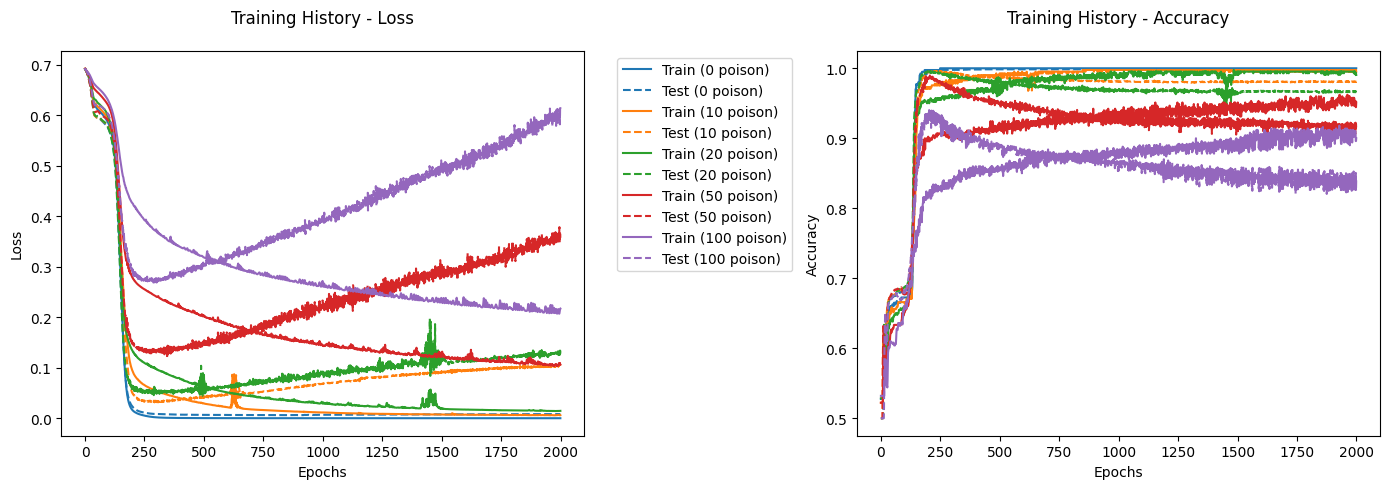

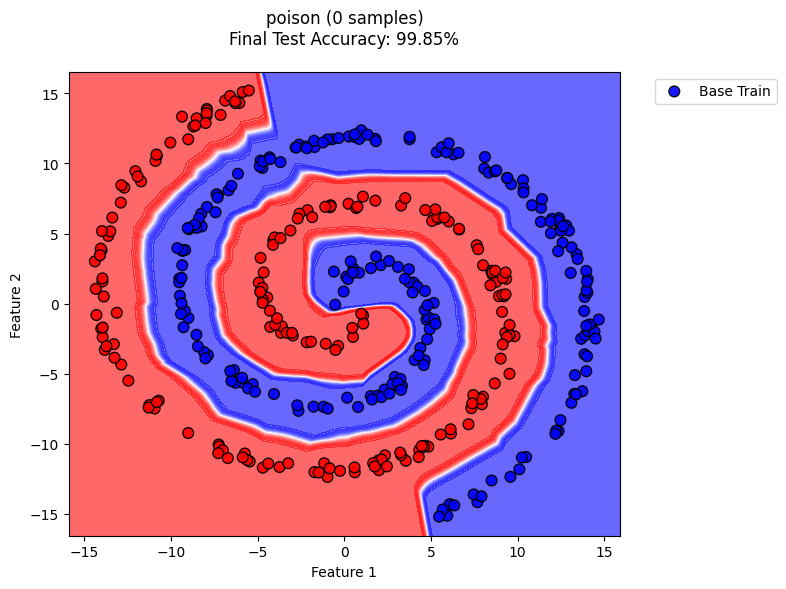

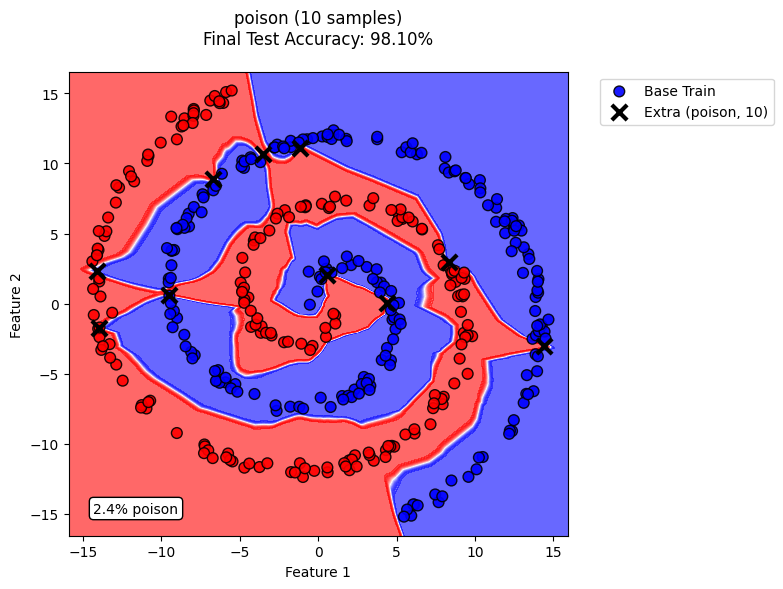

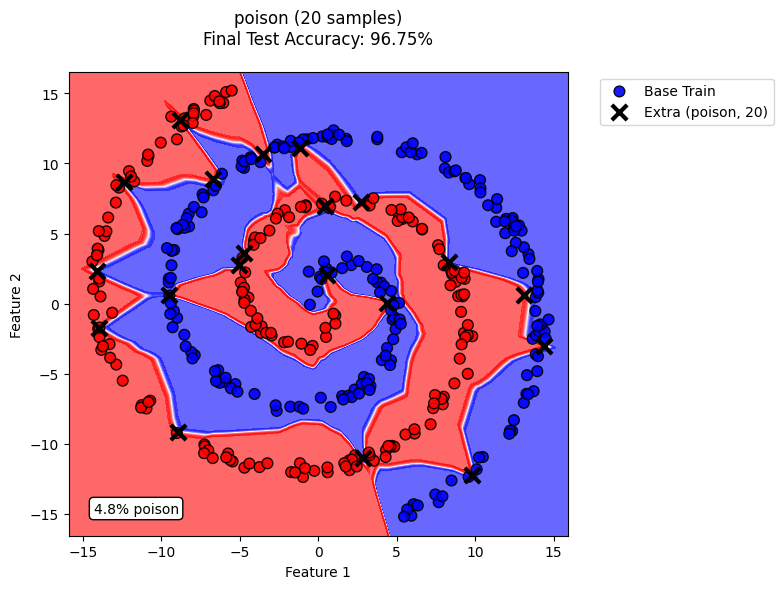

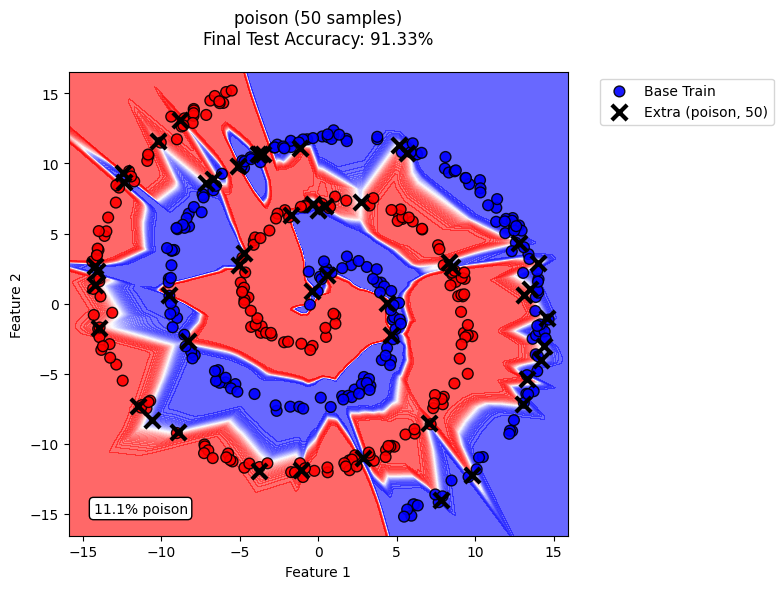

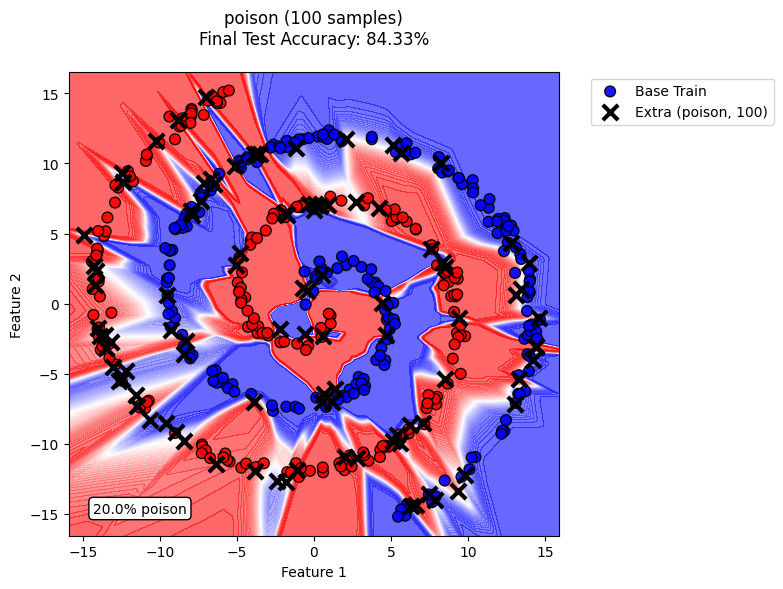

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
